In [57]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras import backend as K
from keras import callbacks 

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
import joblib


**Define input data and plot them**

In [58]:
# Define lookback and prediction time_step
lookback = 10
time_step = 1 
test_size = 10
future_size = 28
n_features = 2
n_outputs=1
patience=500

n_epochs=1500

In [59]:
#number od days
n = 59

final_sequence = []
increment = 10

final_sequence=[increment+2*i for i in range(n)]
final_sequence[0:5]

#convert into df
data_origin=pd.DataFrame(final_sequence, columns=['value'])
data_origin.head(16)

,value
0,10
1,12
2,14
3,16
4,18
5,20
6,22
7,24
8,26
9,28


In [60]:
def zero_value(data):
    data.loc[data['weekend'] == 1, 'value'] = 0
    return data

In [61]:
data_origin['date']=pd.date_range('2022-01-01', periods=len(data_origin))
data_origin['weekend']=data_origin['date'].dt.weekday
data_origin['weekend']=data_origin['weekend'].apply(lambda x: 1 if x in [5,6] else 0)

#zero the weekends values
data_origin = zero_value(data_origin)

#set the index
data_origin.set_index('date', inplace=True)
data_origin.head(8)

,value,weekend
date,,
2022-01-01,0,1
2022-01-02,0,1
2022-01-03,14,0
2022-01-04,16,0
2022-01-05,18,0
2022-01-06,20,0
2022-01-07,22,0
2022-01-08,0,1


In [62]:
""" #add column holidays
data['holidays']=0

#choose some days as holidays 
list_hol=[10,52,93]

for item in list_hol:
    data.loc[item, 'holidays']=1
    data.loc[item, 'value']=0 """

" #add column holidays\ndata['holidays']=0\n\n#choose some days as holidays \nlist_hol=[10,52,93]\n\nfor item in list_hol:\n    data.loc[item, 'holidays']=1\n    data.loc[item, 'value']=0 "

In [63]:
data_origin.tail(8)

,value,weekend
date,,
2022-02-21,112,0
2022-02-22,114,0
2022-02-23,116,0
2022-02-24,118,0
2022-02-25,120,0
2022-02-26,0,1
2022-02-27,0,1
2022-02-28,126,0


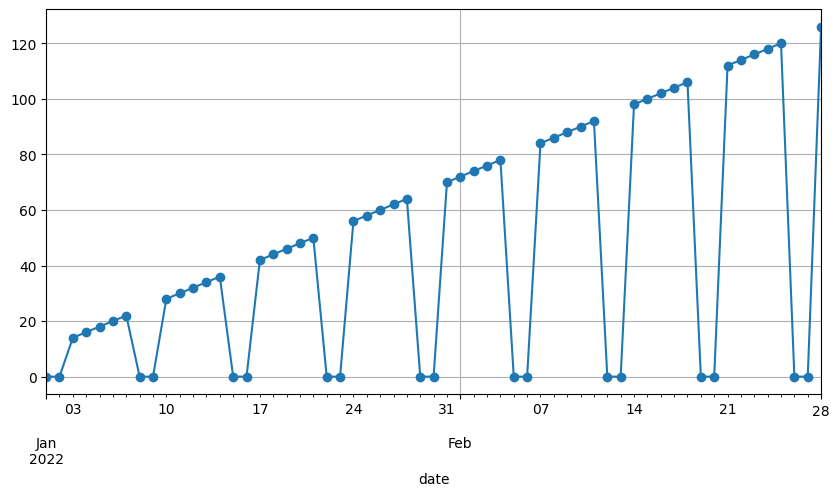

In [64]:
data_origin['value'].plot(figsize=(10,5), marker='o')
plt.grid()
plt.show()

**Scale and parce the data**

In [65]:
#scale data
scaler = MinMaxScaler(feature_range= (0,1))
data = scaler.fit_transform(data_origin)

In [66]:
# Function to create input sequences and corresponding output for training
def create_sequences(data, lookback, time_step):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback, :])
        y.append(data[i+lookback:i+lookback+time_step, 0]) #I want to predict just first feature that is why 0
    return np.array(X), np.array(y)

# Create input sequences and corresponding output
X, y = create_sequences(data, lookback, time_step)

In [67]:
#Split the data into training and testing sets
train_size = int(len(X)-test_size)

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [68]:
y_train.shape

(39, 1)

**Build the NN and compute**

In [69]:
#Build the LSTM model

'''
If you encounter this problem:
"The error AttributeError: module 'keras.backend' has no attribute 'floatx'"
Restart VSC!!!
'''

#clear previous TensorFlow session
K.clear_session()

model = Sequential()
model.add(LSTM(40, input_shape=(lookback, n_features)))
model.add(Dense(time_step))
model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                6880      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 6921 (27.04 KB)
Trainable params: 6921 (27.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Fit the model and run the computation**

In [70]:
#set the early stopping
early_stopping=callbacks.EarlyStopping(patience=patience)

#Train the model
history=model.fit(X_train, y_train, 
                  epochs=n_epochs, 
                  batch_size=10, 
                  validation_data=(X_test, y_test), 
                  callbacks=[early_stopping],
                  verbose=0)

#Evaluate the model on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

1/1 [==============================] - 0s 250ms/step - loss: 9.2809e-04
Test Loss: 0.0009280924568884075


In [71]:
#define ploting function for loss function

def plot_training(history_dict, y_axis=[0, 1000]):

    plt.plot(history_dict.history['loss'], label='Loss-Training',  c="blue")
    plt.plot(history_dict.history['val_loss'], label='Loss-Test', c="red")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.ylim(y_axis) #limit of the Y-axis

    plt.legend()
    plt.grid(True)

    plt.show()

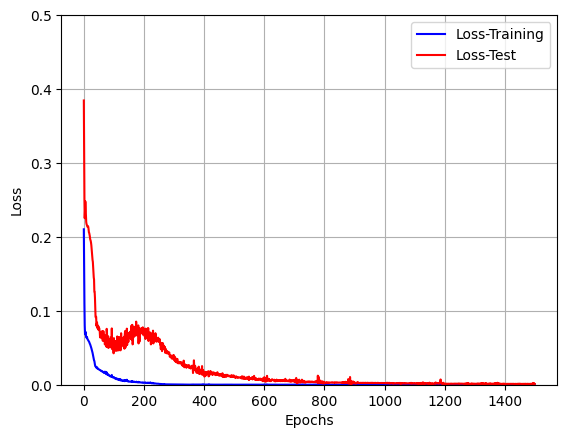

In [72]:
#plot without dropout
plot_training(history,y_axis=[0, 0.5])

**Predict on the test data**

In [73]:
#Predict the next time steps
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 245ms/step


**Back-transformation**

In [74]:
#check shape
y_pred.shape

(10, 1)

In [75]:
def back_transform(df, n_features=n_features, n_outputs=n_outputs, array=True):

    #duplicate the array - for transformations reasons
    transformed_array = np.repeat(df, n_features, axis=-1)

    #slice the array
    transformed_array=transformed_array[:,0:n_features]

    #tranform back
    transformed_array=scaler.inverse_transform(transformed_array)[:,0:n_outputs]
    
    #create a dataframe
    if array !=True:
        transformed_array=pd.DataFrame(transformed_array, columns=['pred1', 'pred2'])

    return transformed_array

In [76]:
y_pred_trans=back_transform(y_pred, n_features=n_features, n_outputs=n_outputs, array=True)

In [77]:
y_test.shape

(10, 1)

In [78]:
y_test_trans=back_transform(y_test, n_features=n_features, n_outputs=n_outputs, array=True)

**Plot results**

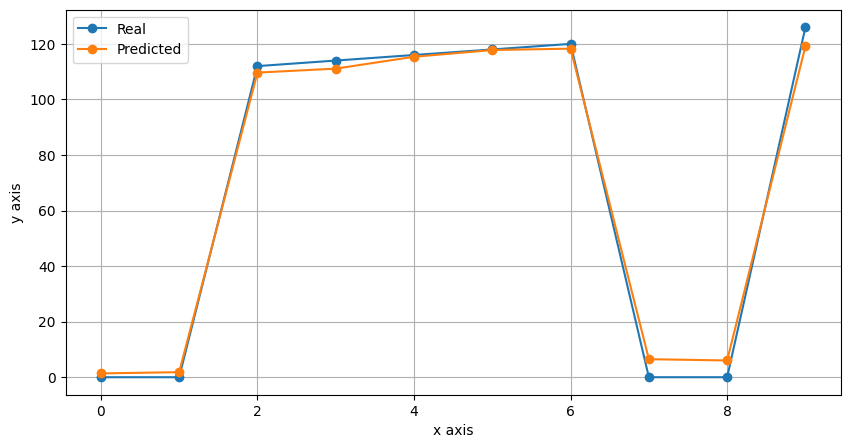

In [79]:
#Plot results for test part

plt.figure(figsize=(10,5))

plt.plot(y_test_trans, label = 'Real', marker='o')
plt.plot(y_pred_trans, label = 'Predicted', marker='o')

plt.grid()
plt.ylabel('y axis')
plt.xlabel('x axis')

plt.legend()
plt.show()

**Evaluate test data - RMSE**

In [80]:
#calculate root mean squared error
test_score = np.sqrt(mse(y_test_trans, y_pred_trans))

#print results
print(f'RMSE: {round(test_score,2)}')


RMSE: 3.84


**Retrain on the whole dataset**

In [81]:
#Fit the model on the whole dataset (including test set)
history=model.fit(X,y, epochs=n_epochs, batch_size=10, verbose=0)
final_loss = history.history['loss'][-1]
final_loss

2.0423156456672587e-05

In [82]:
#Save the fitted model
joblib.dump(model, 'lstm-model-multivariate.pkl')

['lstm-model-multivariate.pkl']

## Predict beyond the test set

**Create a matrix**

In [83]:
#get the last date item
first_date=data_origin.index[-1]+pd.Timedelta(days=1)
first_date

Timestamp('2022-03-01 00:00:00')

In [84]:
#get the future prediction
df_future=pd.DataFrame({'date': pd.date_range(first_date,periods=future_size)})

#add nan we will predict them
df_future['value']=np.nan

#add weekend column
df_future['weekend']=df_future['date'].dt.weekday
df_future['weekend']=df_future['weekend'].apply(lambda x: 1 if x in [5,6] else 0)
df_future=df_future.set_index('date')

df_future

,value,weekend
date,,
2022-03-01,NaN,0
2022-03-02,NaN,0
2022-03-03,NaN,0
2022-03-04,NaN,0
2022-03-05,NaN,1
2022-03-06,NaN,1
2022-03-07,NaN,0
2022-03-08,NaN,0
2022-03-09,NaN,0


In [85]:
#take data from the test set
#add nan we will predict them
df_test=data_origin[-test_size:].copy()
df_test

,value,weekend
date,,
2022-02-19,0,1
2022-02-20,0,1
2022-02-21,112,0
2022-02-22,114,0
2022-02-23,116,0
2022-02-24,118,0
2022-02-25,120,0
2022-02-26,0,1
2022-02-27,0,1


In [86]:
#merge the df
df_prediction_final=pd.concat([df_test, df_future], axis=0)
df_prediction_final

,value,weekend
date,,
2022-02-19,0.0,1
2022-02-20,0.0,1
2022-02-21,112.0,0
2022-02-22,114.0,0
2022-02-23,116.0,0
2022-02-24,118.0,0
2022-02-25,120.0,0
2022-02-26,0.0,1
2022-02-27,0.0,1


In [87]:
#scale data and transform them into an array
scaler = MinMaxScaler(feature_range = (0,1))
df_prediction_final_scaled = scaler.fit_transform(df_prediction_final)

In [88]:
#array BEFORE the prediction
df_prediction_final_scaled 

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.88888889, 0.        ],
       [0.9047619 , 0.        ],
       [0.92063492, 0.        ],
       [0.93650794, 0.        ],
       [0.95238095, 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 1.        ],
       [       nan, 1.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 1.        ],
       [       nan, 1.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 0.        ],
       [       nan, 1.        ],
       [       nan, 1.        ],
       [  

In [98]:
#define the function for the prediction
def predict_multivariate(array, lookback):
    results=[]
    for i in range(len(array)-lookback):
        
        batch=[]
        batch.append(array[i:i+lookback , 0:array.shape[1]])
        batch=np.array(batch)
      
        #predict one value
        prediction=model.predict(batch, verbose=0)[0]
        #add to the prediction list
        results.append(prediction[0]) #takes just first values, otherwise there would be a list with 2D arrays

        #replace nan in the array for next iterration
        array[i+lookback,0]=prediction[0] 
    return array[-future_size:, 0:n_outputs]

In [124]:
#call the function and predict
results=predict_multivariate(df_prediction_final_scaled, lookback)
results

array([[1.00107133],
       [1.01914763],
       [1.040892  ],
       [1.05425346],
       [0.01024994],
       [0.00677635],
       [1.09103036],
       [1.08853781],
       [1.10641325],
       [1.13206768],
       [1.14236152],
       [0.0191342 ],
       [0.01333583],
       [1.17029369],
       [1.16121113],
       [1.17770243],
       [1.20459616],
       [1.21460009],
       [0.03041327],
       [0.02151258],
       [1.23162365],
       [1.21761346],
       [1.23315883],
       [1.25928915],
       [1.26966238],
       [0.04209415],
       [0.03049543],
       [1.27664781]])

In [125]:
#array AFTER the prediction
df_prediction_final_scaled

array([[0.        , 1.        ],
       [0.        , 1.        ],
       [0.88888889, 0.        ],
       [0.9047619 , 0.        ],
       [0.92063492, 0.        ],
       [0.93650794, 0.        ],
       [0.95238095, 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.00107133, 0.        ],
       [1.01914763, 0.        ],
       [1.040892  , 0.        ],
       [1.05425346, 0.        ],
       [0.01024994, 1.        ],
       [0.00677635, 1.        ],
       [1.09103036, 0.        ],
       [1.08853781, 0.        ],
       [1.10641325, 0.        ],
       [1.13206768, 0.        ],
       [1.14236152, 0.        ],
       [0.0191342 , 1.        ],
       [0.01333583, 1.        ],
       [1.17029369, 0.        ],
       [1.16121113, 0.        ],
       [1.17770243, 0.        ],
       [1.20459616, 0.        ],
       [1.21460009, 0.        ],
       [0.03041327, 1.        ],
       [0.02151258, 1.        ],
       [1.

In [126]:
results_trans=back_transform(results, n_features=n_features, n_outputs=n_outputs, array=True)

In [127]:
results_trans.shape

(28, 1)

In [130]:
results_trans=results_trans.reshape(-1)

In [131]:
results_trans.shape

(28,)

**Plot the results**

In [133]:
#create dataframe
results_df=pd.DataFrame({'predicted': results_trans,
                         'date': pd.date_range(first_date,periods=future_size) })

results_df=results_df.set_index('date')

results_df.head(5)

,predicted
date,
2022-03-01,126.134988
2022-03-02,128.412602
2022-03-03,131.152393
2022-03-04,132.835936
2022-03-05,1.291493


In [134]:
df_prediction=pd.concat([data_origin['value'], results_df], axis=1)
df_prediction.rename(columns={'value': 'true'}, inplace=True)
df_prediction.tail(16)

,true,predicted
date,,
2022-03-13,NaN,1.680315
2022-03-14,NaN,147.457005
2022-03-15,NaN,146.312603
2022-03-16,NaN,148.390506
2022-03-17,NaN,151.779116
2022-03-18,NaN,153.039611
2022-03-19,NaN,3.832072
2022-03-20,NaN,2.710585
2022-03-21,NaN,155.184580


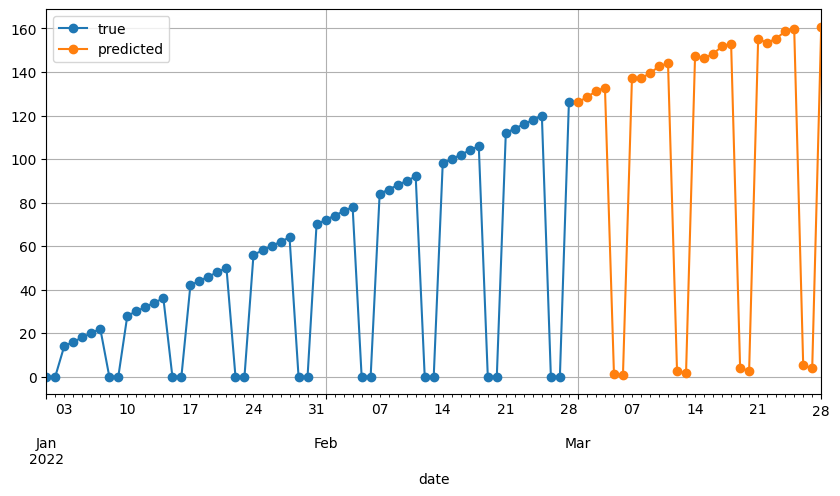

In [135]:
#Plot a chart
df_prediction[['true', 'predicted']].plot(figsize=(10, 5), marker='o')
plt.grid(True)
plt.show()